# Brain Tumor MRI Segmentation

## Setup

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sn

from keras.datasets import mnist
import tensorflow.keras as kb
from tensorflow.keras import backend
import tensorflow as tf

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import VGG16

from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing import image

from matplotlib import pyplot as plt
from plotnine import *

from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, r2_score, f1_score

from sklearn.linear_model import LinearRegression # Linear Regression Model
from sklearn.preprocessing import StandardScaler #Z-score variables

from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import LeaveOneOut #LOO cv

## Background of Data




## Reading in and Setting Up Data

In [ ]:
# make kaggle directory
!mkdir ~/.kaggle

# move kaggle.json to hidden kaggle folder
!cp kaggle.json ~/.kaggle/

# change permissions on file
!chmod 600 ~/.kaggle/kaggle.json

# download zipped data
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

 94% 139M/149M [00:01<00:00, 118MB/s]
100% 149M/149M [00:01<00:00, 124MB/s]
100% 713M/714M [00:09<00:00, 101MB/s] 
100% 714M/714M [00:09<00:00, 76.3MB/s]


In [ ]:
!unzip -qq brain-tumor-mri-dataset.zip

In [ ]:
!unzip -qq lgg-mri-segmentation.zip

In [ ]:
train_dir = "./Training"
test_dir = "./Testing"

In [ ]:
batch_size = 32
image_width = 224
image_height = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir, # file path
  seed = 393, # seed
  image_size = (image_width, image_height), # size of image
  batch_size = batch_size, # number of images per batch
  labels ='inferred',  # Use inferred labels from subdirectories
  label_mode ='categorical') # One-hot encode the labels

Found 5712 files belonging to 4 classes.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir, # file path
  seed = 393, # seed
  image_size = (image_width, image_height), # size of image
  batch_size = batch_size, # number of images per batch
  labels ='inferred',  # Use inferred labels from subdirectories
  label_mode ='categorical') # One-hot encode the labels

Found 1311 files belonging to 4 classes.


## First Dataset

### Understanding Data

In [ ]:
from glob import glob

msk_paths = glob('./kaggle_3m/*/*_mask*')
img_paths = [m.replace('_mask','') for m in msk_paths]

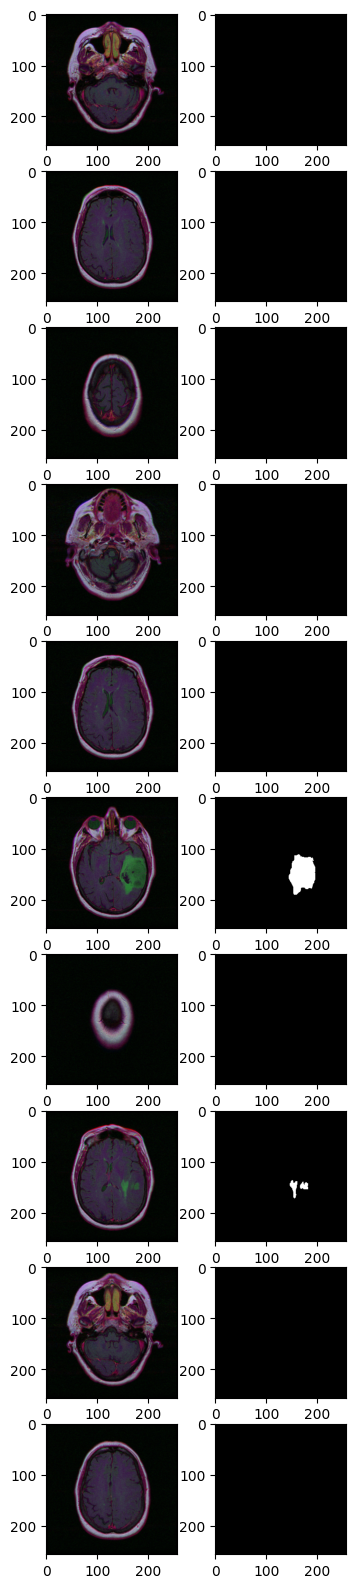

In [ ]:
import cv2

rows, cols = 10, 2

fig = plt.figure(figsize = (4, 20))
for i in range(1, rows*cols, 2):

    fig.add_subplot(rows, cols, i)
    img = cv2.imread(img_paths[i])
    plt.imshow(img)

    fig.add_subplot(rows, cols, i+1)
    msk = cv2.imread(msk_paths[i])
    plt.imshow(msk)

### Preprocessing Data

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

In [ ]:
directory = []
image_files = []
mask_files = []
for dirname, _, filenames in os.walk('./kaggle_3m/'):
    for filename in filenames:
        if 'mask'in filename:
            directory.append(dirname.replace('./kaggle_3m/', ''))
            mask_files.append(filename)
            image_files.append(filename.replace('_mask', ''))

In [ ]:
samples_df = pd.DataFrame({'directory':directory, 'images': image_files, 'masks': mask_files})

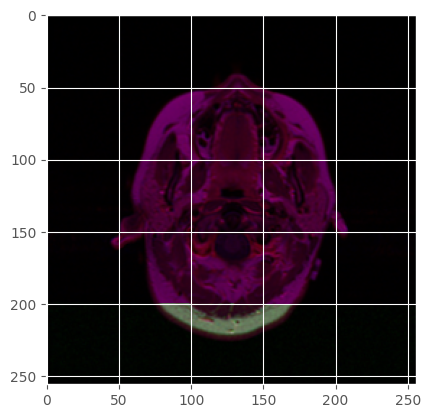

In [ ]:
idx = random.randint(0, len(samples_df))
image_path = os.path.join('./kaggle_3m/', samples_df['directory'].iloc[idx], samples_df['images'].iloc[idx])
mask_path = os.path.join('./kaggle_3m/', samples_df['directory'].iloc[idx], samples_df['masks'].iloc[idx])
img = cv2.imread(image_path)
msk = cv2.imread(mask_path)
plt.imshow(img)
plt.imshow(msk, alpha=0.3)

In [ ]:
def plotImages():
    idx = np.random.randint(0, len(samples_df))

    imagePath = os.path.join('./kaggle_3m/', samples_df['directory'].iloc[idx], samples_df['images'].iloc[idx])
    maskPath = os.path.join('./kaggle_3m/', samples_df['directory'].iloc[idx], samples_df['masks'].iloc[idx])

    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)

    fig, axs = plt.subplots(1,3, figsize=[13,15])

    axs[0].imshow(image)
    axs[0].set_title('Brain MRI')

    axs[1].imshow(mask)
    axs[1].set_title('Mask')

    axs[2].imshow(image)
    axs[2].imshow(mask, alpha=0.3)
    axs[2].set_title('MRI with mask')

    plt.grid(False)
    plt.show()

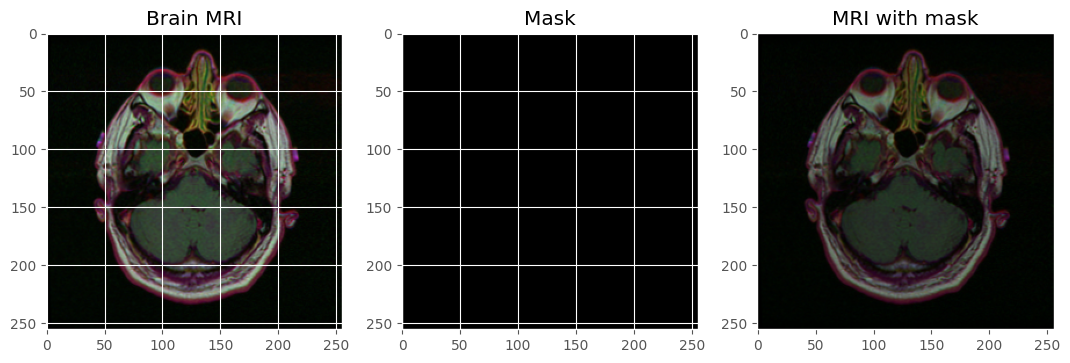

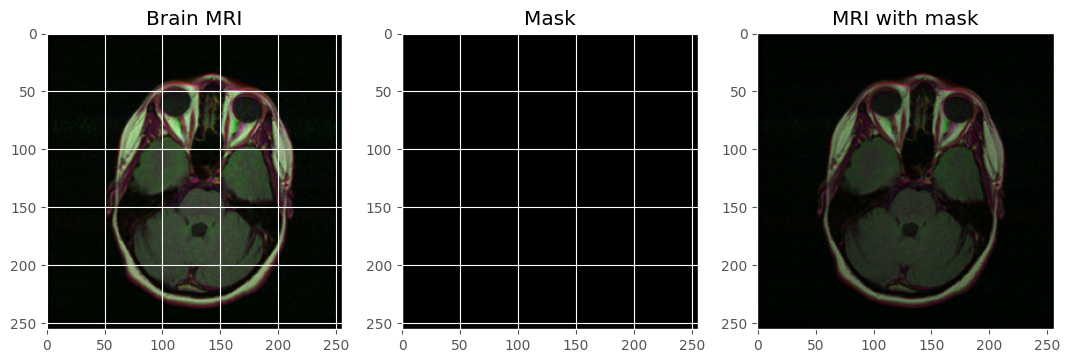

In [ ]:
for i in range(2):
    plotImages()

### Setup

In [ ]:
samples_df['image_path'] = './kaggle_3m/' + samples_df['directory'] + '/' + samples_df['images']
samples_df['mask_path'] = './kaggle_3m/' + samples_df['directory'] + '/' + samples_df['masks']

In [ ]:
train, test = train_test_split(samples_df, test_size = 0.20, random_state = 393)
(EPOCHS, BATCH_SIZE, IMGHEIGHT, IMGWIDTH, CHANNELS) = (35, 32, 224, 224, 3)

In [ ]:
data_aug_dict = dict(rotation_range = 0.4,
                    width_shift_range = 0.05,
                    height_shift_range = 0.05,
                    shear_range = 0.02,
                    zoom_range = 0.04,
                    vertical_flip = True)

In [ ]:
image_gen = ImageDataGenerator(rescale = 1./255., **data_aug_dict)
mask_gen = ImageDataGenerator(rescale = 1./255., **data_aug_dict)

train_image_gen = image_gen.flow_from_dataframe(dataframe=train,
                                                x_col = 'image_path',
                                                class_mode = None,
                                                batch_size = BATCH_SIZE,
                                                seed = 393,
                                                target_size = (IMGHEIGHT, IMGWIDTH),
                                                color_mode = 'rgb')

train_mask_gen = image_gen.flow_from_dataframe(dataframe=train,
                                              class_mode=None,
                                              x_col = 'mask_path',
                                              batch_size = BATCH_SIZE,
                                              seed = 393,
                                              target_size = (IMGHEIGHT, IMGWIDTH),
                                              color_mode = 'grayscale')

Found 1837 validated image filenames.
Found 1837 validated image filenames.


In [ ]:
image_gen = ImageDataGenerator(rescale = 1./255.)
mask_gen = ImageDataGenerator(rescale = 1./255.)

valid_image_gen = image_gen.flow_from_dataframe(dataframe = test, x_col = 'image_path', class_mode = None, batch_size = BATCH_SIZE, seed = 393, target_size = (IMGHEIGHT, IMGWIDTH), color_mode = 'rgb')

valid_mask_gen = image_gen.flow_from_dataframe(dataframe = test, class_mode = None, x_col = 'mask_path', batch_size = BATCH_SIZE, seed = 393, target_size = (IMGHEIGHT, IMGWIDTH), color_mode = 'grayscale')

Found 460 validated image filenames.
Found 460 validated image filenames.


In [ ]:
def dataIterator(image_gen, mask_gen):
    for img, mask in zip(image_gen, mask_gen):
        yield img, mask

In [ ]:
train_gen = dataIterator(train_image_gen, train_mask_gen)
valid_gen = dataIterator(valid_image_gen, valid_mask_gen)

### Building Model

In [ ]:
IMG_WIDTH, IMG_HEIGHT, CHANNELS = (224, 224, 3)

In [ ]:
STEP_SIZE_TRAIN = train_image_gen.n/BATCH_SIZE
STEP_SIZE_VALID = valid_image_gen.n/BATCH_SIZE

In [ ]:
def conv2dBlock(input_tensor, n_filters, kernel_size = 3, batchnorm = True):

    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

In [ ]:
import tensorflow as tf

# define the dice coefficient function
def dice_coefficient(y_true, y_pred):
    smooth = 1.0
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)


In [ ]:
STEP_SIZE_TRAIN = train_image_gen.n/BATCH_SIZE
STEP_SIZE_VALID = valid_image_gen.n/BATCH_SIZE

#### Original

In [ ]:
def getUnet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):

    # Contracting Path
    c1 = conv2dBlock(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2dBlock(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2dBlock(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2dBlock(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2dBlock(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    p5 = MaxPooling2D((2, 2))(c5)
    p5 = Dropout(dropout)(p5)

    c6 = conv2dBlock(p5, n_filters = n_filters * 32, kernel_size = 3, batchnorm = batchnorm)

    # Expansive Path
    u6 = Conv2DTranspose(n_filters*16, (3, 3), strides=(2,2), padding='same')(c6)
    u6 = concatenate([u6, c5])
    u6 = Dropout(dropout)(u6)
    c7 = conv2dBlock(u6, n_filters*16, kernel_size = 3, batchnorm = batchnorm)

    u7 = Conv2DTranspose(n_filters*8, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u7 = concatenate([u7, c4])
    u7 = Dropout(dropout)(u7)
    c8 = conv2dBlock(u7, n_filters*8, kernel_size = 3, batchnorm = batchnorm)

    u8 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u8 = concatenate([u8, c3])
    u8 = Dropout(dropout)(u8)
    c9 = conv2dBlock(u8, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c9)
    u9 = concatenate([u9, c2])
    u9 = Dropout(dropout)(u9)
    c10 = conv2dBlock(u9, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    u10 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c10)
    u10 = concatenate([u10, c1])
    u10 = Dropout(dropout)(u10)
    c11 = conv2dBlock(u10, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(1, (1, 1), activation = 'sigmoid')(c11)
    model = Model(inputs = [input_img], outputs = [outputs])
    return model

In [ ]:
input_img1 = Input((IMG_HEIGHT, IMG_WIDTH, CHANNELS), name='img')
model = getUnet(input_img1, n_filters = 16, dropout = 0.2, batchnorm=True)
model.compile(optimizer = Adam(), loss = "binary_crossentropy", metrics = ["accuracy", dice_coefficient])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img (InputLayer)            [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 224, 224, 16)         448       ['img[0][0]']                 
                                                                                                  
 batch_normalization_1 (Bat  (None, 224, 224, 16)         64        ['conv2d_1[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_1 (Activation)   (None, 224, 224, 16)         0         ['batch_normalization_1[0]

### Training Model

In [ ]:
historyUNetv1 = model.fit(train_gen,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    batch_size = BATCH_SIZE,
                    epochs = 30,
                    validation_data = valid_gen,
                    validation_steps = STEP_SIZE_VALID)

Epoch 1/30
57/57 [==============================] - 834s 14s/step - loss: 0.5612 - accuracy: 0.7844 - dice_coefficient: 0.0273 - val_loss: 1.3214 - val_accuracy: 0.5441 - val_dice_coefficient: 0.0278
Epoch 2/30
57/57 [==============================] - 824s 14s/step - loss: 0.2801 - accuracy: 0.9915 - dice_coefficient: 0.0439 - val_loss: 0.6808 - val_accuracy: 0.5241 - val_dice_coefficient: 0.0274
Epoch 3/30
57/57 [==============================] - 827s 14s/step - loss: 0.1981 - accuracy: 0.9925 - dice_coefficient: 0.0565 - val_loss: 0.1891 - val_accuracy: 0.9888 - val_dice_coefficient: 0.0260
Epoch 4/30
57/57 [==============================] - 801s 14s/step - loss: 0.1498 - accuracy: 0.9920 - dice_coefficient: 0.0697 - val_loss: 0.1372 - val_accuracy: 0.9898 - val_dice_coefficient: 0.0452
Epoch 5/30
57/57 [==============================] - 797s 14s/step - loss: 0.1111 - accuracy: 0.9926 - dice_coefficient: 0.0928 - val_loss: 0.1036 - val_accuracy: 0.9904 - val_dice_coefficient: 0.0565


#### Measuring Performance

In [ ]:
test_loss, test_accuracy, test_dice_coef = model.evaluate(valid_gen, steps = STEP_SIZE_VALID, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Dice Coefficient: {test_dice_coef}")

14/14 [==============================] - 44s 3s/step - loss: 0.0151 - accuracy: 0.9947 - dice_coefficient: 0.6365
Test Loss: 0.015095273032784462
Test Accuracy: 0.994675874710083
Test Dice Coefficient: 0.6364822387695312


<function matplotlib.pyplot.show(close=None, block=None)>

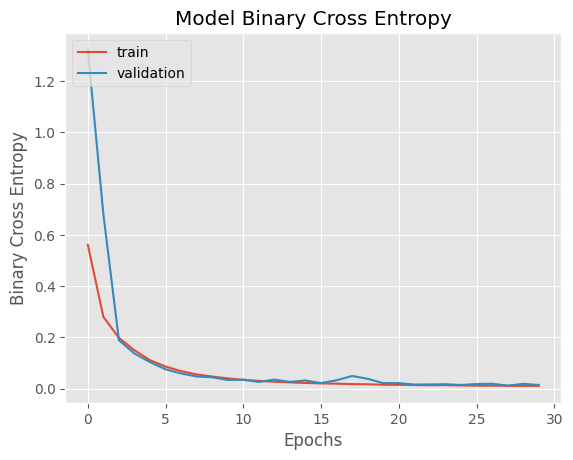

In [ ]:
plt.plot(historyUNetv1.history["loss"])
plt.plot(historyUNetv1.history["val_loss"])
plt.title("Model Binary Cross Entropy")
plt.ylabel("Binary Cross Entropy")
plt.xlabel("Epochs")
plt.legend(["train", "validation"], loc = "upper left")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

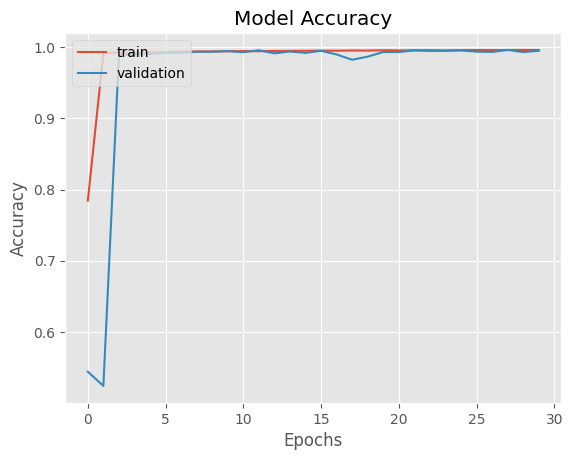

In [ ]:
plt.plot(historyUNetv1.history["accuracy"])
plt.plot(historyUNetv1.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "validation"], loc = "upper left")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

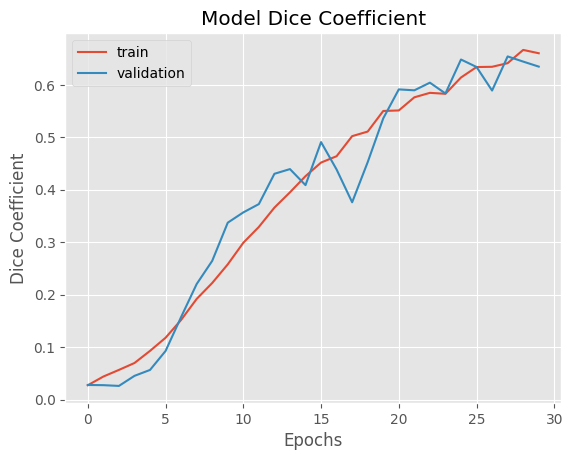

In [ ]:
plt.plot(historyUNetv1.history["dice_coefficient"])
plt.plot(historyUNetv1.history["val_dice_coefficient"])
plt.title("Model Dice Coefficient")
plt.ylabel("Dice Coefficient")
plt.xlabel("Epochs")
plt.legend(["train", "validation"], loc = "upper left")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

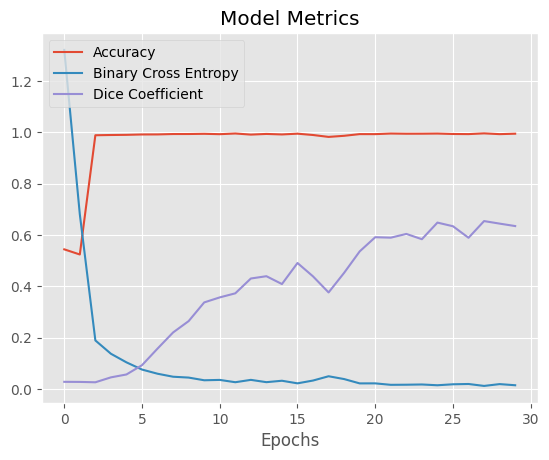

In [ ]:
plt.plot(historyUNetv1.history["val_accuracy"])
plt.plot(historyUNetv1.history["val_loss"])
plt.plot(historyUNetv1.history["val_dice_coefficient"])
plt.title("Model Metrics")
plt.xlabel("Epochs")
plt.legend(["Accuracy", "Binary Cross Entropy", "Dice Coefficient"], loc = "upper left")
plt.show

#### Visualizing Results

In [ ]:
for i in range(5):
    idx = np.random.randint(0, len(samples_df))

    imagePath = os.path.join('./kaggle_3m/', samples_df['directory'].iloc[idx], samples_df['images'].iloc[idx])
    maskPath = os.path.join('./kaggle_3m/', samples_df['directory'].iloc[idx], samples_df['masks'].iloc[idx])

    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)

    img = cv2.resize(image ,(IMGHEIGHT, IMGWIDTH))

    img = img / 224
    img = img[np.newaxis, :, :, :]

    pred = model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,4,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')

    plt.subplot(1,4,2)
    plt.imshow(mask)
    plt.title('Original Mask')

    plt.subplot(1,4,3)
    plt.imshow(np.squeeze(pred))
    plt.title('Prediction')

    plt.subplot(1,4,4)
    plt.imshow(np.squeeze(pred) > 0.5)
    plt.title('BinaryPrediction')
    plt.show()

## Second Dataset

### Understanding Data

<Axes: title={'center': 'Data Balance'}>

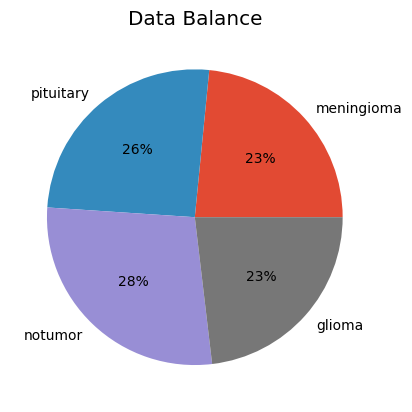

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import random
import cv2
import os


# read dataset folder and storing file paths in an organized dictionary in "folder: List[filename]"" formate
data = {}
for root, _, filenames in os.walk('./Training'):
    dirname = root.split('/')[-1]

    for filename in filenames:

        if dirname not in data.keys():
            data[dirname] = []

        data[dirname].append(os.path.join(root, filename))

# drawing an pie plot for data balance
ds = pd.Series([len(data[k]) for k in data.keys()], index = data.keys())
ds.plot(title='Data Balance', kind='pie', autopct='%1.0f%%')

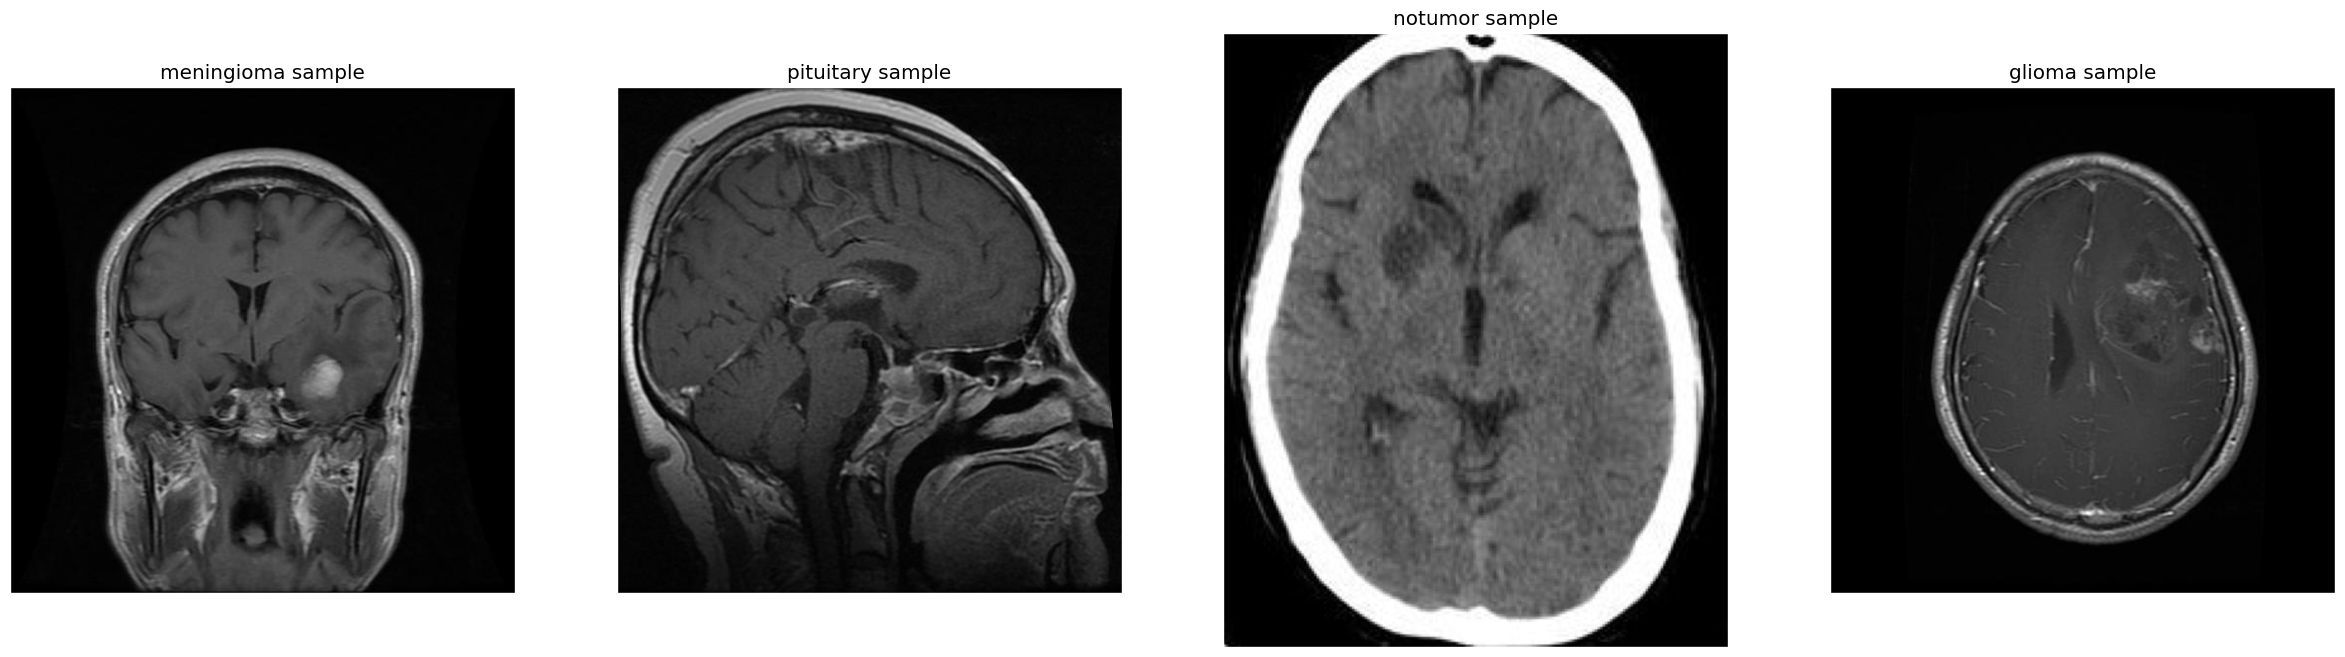

In [ ]:
# reading random samples from each class
plt.figure(figsize=(30, 20))

samples = []
for i, k in enumerate(data.keys()):
    s = cv2.imread(random.choice(data[k]))
    s = cv2.cvtColor(s, cv2.COLOR_BGR2GRAY)
    samples.append(s)

    plt.subplot(1, 4, i + 1)
    plt.imshow(samples[-1], cmap='gray')
    plt.title(k + ' sample')
    plt.xticks([])
    plt.yticks([])

plt.show()

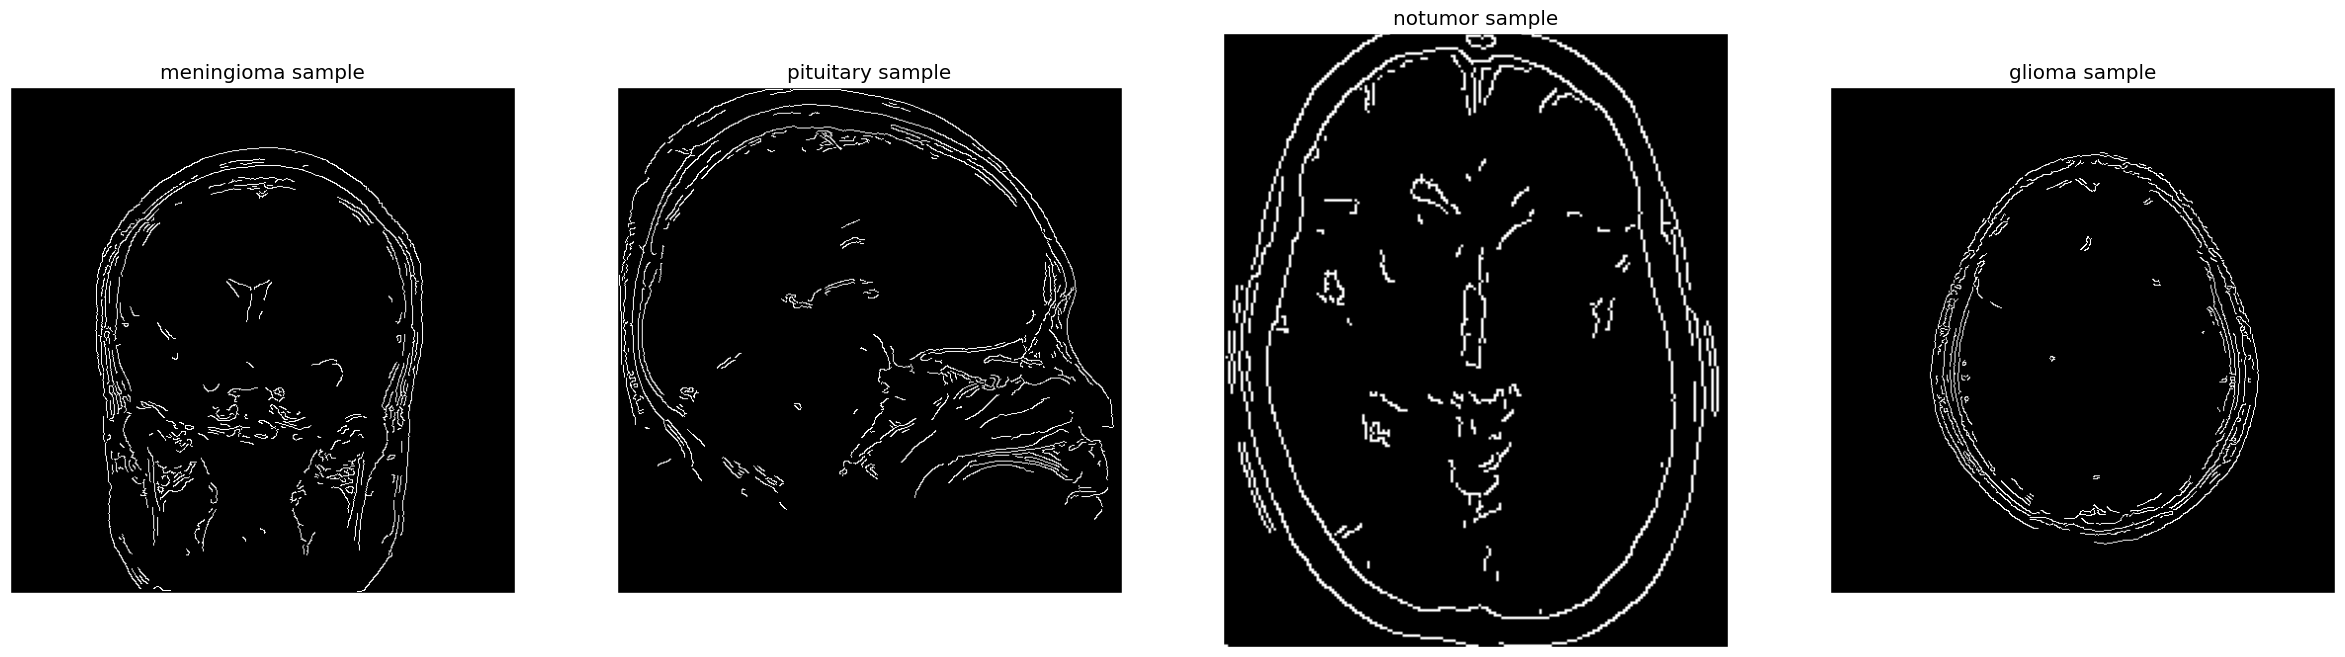

In [ ]:
# applying Edge Detection
plt.figure(figsize=(30, 20))

for i, s in enumerate(samples):
    s = cv2.Canny(s, threshold1=140, threshold2=210)

    plt.subplot(1, 4, i + 1)
    plt.imshow(s, cmap='gray')
    plt.title(list(data.keys())[i] + ' sample')
    plt.xticks([])
    plt.yticks([])

### Preprocessing Data

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

num_classes = 4  # 3 tumor types + no tumor
input_shape = (image_width, image_height, 1)

In [ ]:
# function to load and preprocess images
def load_image(image_paths, target_size=(224, 224)):
    images = []
    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, target_size) if img is not None else np.zeros(target_size, dtype = np.uint8)
        images.append(img)
    return np.array(images)

train_images = []
test_images = []

categories = ['glioma', 'meningioma', 'pituitary', 'notumor']

for category in categories:
    train_image_paths = [os.path.join('./Training', category, filename) for filename in os.listdir(f'./Training/{category}')]
    test_image_paths = [os.path.join('./Testing', category, filename) for filename in os.listdir(f'./Testing/{category}')]

    train_images.extend(load_image(train_image_paths))
    test_images.extend(load_image(test_image_paths))

In [ ]:
train_images = np.array(train_images)
test_images = np.array(test_images)

print(train_images.shape)
print(test_images.shape)

(5712, 224, 224)
(1311, 224, 224)


In [ ]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# function to get categorical labels
def get_categorical_labels(image_paths):
    labels = [os.path.basename(os.path.dirname(path)) for path in image_paths]

    # encode labels into integers
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)

    # convert encoded labels to categorical one-hot vectors
    categorical_labels = to_categorical(encoded_labels, num_classes=len(label_encoder.classes_))

    return categorical_labels

In [ ]:
import os
import cv2
import numpy as np

def load_labels_train(image_filename, category_folders, target_size=(224, 224)):
    labels = []

    for category in category_folders:
        file = os.path.join('./Training', category, image_filename)
        label = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        label_resized = cv2.resize(label, target_size) if label is not None else np.zeros(target_size, dtype=np.uint8)
        labels.append(label_resized)

    # merge separate category labels into a single multi-class label
    merged_label = np.stack(labels, axis=-1)
    return merged_label

In [ ]:
category_folders = ['glioma', 'meningioma', 'pituitary', 'notumor']

# Initialize a set to collect unique image filenames
all_image_filenames_train = set()

# Collect image filenames from all category folders
for category in category_folders:
    folder_path = os.path.join('./Training', category)
    image_filenames = os.listdir(folder_path)
    all_image_filenames_train.update(image_filenames)

# Convert the set of unique filenames to a list
all_image_filenames_train = list(all_image_filenames_train)

# Load labels for these image filenames
train_labels = [load_labels_train(image_filename, category_folders) for image_filename in all_image_filenames_train]

num_classes = 4
categorical_train_labels = np.array(train_labels)

In [ ]:
print(categorical_train_labels)
print(categorical_train_labels.shape)

In [ ]:
import os
import cv2
import numpy as np

def load_labels_test(image_filename, category_folders, target_size=(224, 224)):
    labels = []

    for category in category_folders:
        file = os.path.join('./Training', category, image_filename)
        label = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        label_resized = cv2.resize(label, target_size) if label is not None else np.zeros(target_size, dtype=np.uint8)
        labels.append(label_resized)

    # merge separate category labels into a single multi-class label
    merged_label = np.stack(labels, axis=-1)
    return merged_label

In [ ]:
category_folders = ['glioma', 'meningioma', 'pituitary', 'notumor']

# Initialize a set to collect unique image filenames
all_image_filenames_test = set()

# Collect image filenames from all category folders
for category in category_folders:
    folder_path = os.path.join('./Testing', category)
    image_filenames = os.listdir(folder_path)
    all_image_filenames_test.update(image_filenames)

# Convert the set of unique filenames to a list
all_image_filenames_test = list(all_image_filenames_test)

# Load labels for these image filenames
test_labels = [load_labels_test(image_filename, category_folders) for image_filename in all_image_filenames_test]

num_classes = 4
categorical_test_labels = np.array(test_labels)

In [ ]:
print(categorical_test_labels)
print(categorical_test_labels.shape)

### Applying Trained Model to Original Dataset

In [ ]:
from tensorflow.keras.models import load_model

# Assuming 'model' is your trained model
model.save('C:/Users/sanje/OneDrive/Documents/CPSC_393/Saved_Models/MRI_Mask_Segmentation.h5')

In [ ]:
from tensorflow.keras.models import load_model

# Load the pre-trained model
model_path = 'C:/Users/sanje/OneDrive/Documents/CPSC_393/Saved_Models/MRI_Mask_Segmentation.h5'
pretrained_model = load_model(model_path, custom_objects={'dice_coefficient': dice_coefficient})

In [ ]:
# Get the weights of the model
weights = pretrained_model.get_weights()

# Save the weights separately
pretrained_model.save_weights('C:/Users/sanje/OneDrive/Documents/CPSC_393/Saved_Models/MRI_Mask_Segmentation_Weights.h5')

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Function to convert grayscale images to RGB format
def grayscale_to_rgb(grayscale_image):
    # Convert single channel grayscale to three channel grayscale
    return np.repeat(grayscale_image[..., np.newaxis], 3, axis=-1)


In [ ]:
# Function to load and preprocess images based on specific paths
def load_and_process_images(image_paths):
    processed_images = []
    for path in image_paths:
        grayscale_img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        grayscale_img = cv2.resize(grayscale_img, (224, 224))  # Resize to match the model's input shape
        rgb_img = grayscale_to_rgb(grayscale_img)
        rgb_img = rgb_img.astype('float32') / 255.0  # Normalize pixel values
        processed_images.append(rgb_img)
    return np.array(processed_images)

In [ ]:
# Define your image paths
selected_image_paths = ['./Testing/glioma/Te-gl_0014.jpg',
                        './Testing/meningioma/Te-me_0027.jpg',
                        './Testing/notumor/Te-noTr_0001.jpg',
                        './Testing/pituitary/Te-pi_0041.jpg']

# Load and preprocess selected images
selected_images = load_and_process_images(selected_image_paths)

# Perform prediction using the RGB-trained model on selected images
predictions = pretrained_model.predict(selected_images)

In [ ]:
# Display original images and their predicted masks
for i in range(len(selected_image_paths)):
    img_path = selected_image_paths[i]
    image = cv2.imread(img_path)

    original_image = cv2.resize(image, (IMGHEIGHT, IMGWIDTH))
    original_image = original_image / 224
    original_image = original_image[np.newaxis, :, :, :]

    pred_mask = predictions[i]

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(pred_mask), cmap='viridis')  # Change colormap as needed
    plt.colorbar()
    plt.title('Probability Map')

    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(pred_mask) > 0.45, cmap='gray')  # Adjust the threshold for visualization
    plt.title('Predicted Mask')

    plt.show()